# Kaggle Competition - Titanic

## Install required libs

In [1]:
!pip install numpy==1.21.3 -q
!pip install pandas==1.3.4 -q
!pip install -U scikit-learn==1.0.1 -q
!pip install kaggle==1.5.12 -q
!pip install matplotlib==3.4.3 -q
!pip install seaborn==0.11.2 -q

## Download the competition files

In [2]:
!kaggle competitions download -c titanic -q

## Extract the competition files from downloaded zip file

In [3]:
import zipfile

with zipfile.ZipFile('titanic.zip', 'r') as file:
    file.extractall('./data')

## Import libraries

In [4]:
import numpy as np
import pandas as pd

In [5]:
# set numpy default random seed
np.random.seed(1)

# Data Preparation

## Load train data

In [6]:
raw_data = pd.read_csv('./data/train.csv')

In [7]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
raw_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Split the data from train and validation sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(raw_data.drop('Survived', axis=1), raw_data['Survived'])

In [11]:
print(f'Train size: {X_train.shape}')
print(f'Validation size: {X_valid.shape}')

Train size: (668, 11)
Validation size: (223, 11)


## Create a dummy Classifier to define a base for performance evaluation

In [12]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

prediction = dummy.predict(X_valid)

In [13]:
from sklearn.metrics import accuracy_score

print(f'Dummy classifier accuracy: {accuracy_score(y_valid, prediction)}')

Dummy classifier accuracy: 0.5739910313901345


The dummy classifier accuracy is 60% acurated, So any real classifier accuracy should be better than the dummy classifier.

## Understand the data

Documentation: [Kaggle](https://www.kaggle.com/c/titanic/data)

In [14]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
35,36,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S
46,47,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.5000,NaN,Q
453,454,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C
291,292,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
748,749,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S


* **PassengerID:** This column doesn't have any important informatgion
* **Pclass:** The passenger socio economic class may have some influence on the result
* **Name:** The name itself is not useful, but the title (Mr, Mrs, ...) may help to fill the null on Age column
* **Sex:** The passenger sex is probably a useful feature
* **Age:** The passenger age is probably a useful feature
* **SibSp:** The passenger SibSp may be a usefull feature
* **Parch:** The passenger Parch may be a usefull feature
* **Ticket:** The passenger ticket number doesn't have any important information
* **Cabin:** The cabin number itself is not useful, but a passenger who owns a cabin may have a better chance to survive
* **Embarked:** The embarked gate is probably a not usefull information

## Create Data Preparation Pipeline

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

### Extract Title from Name

The first step is to list all available titles to list the possible values

In [16]:
import re

re_title = re.compile('([A-Za-z]+)\.')

raw_data['Name'].map(lambda x: re_title.findall(x)[0]).value_counts().to_frame().T

,Mr,Miss,Mrs,Master,Dr,Rev,Mlle,Major,Col,Countess,Capt,Ms,Sir,Lady,Mme,Don,Jonkheer
Name,517,182,125,40,7,6,2,2,2,1,1,1,1,1,1,1,1


Probably we can keep just the 4 most common titles and set others based on gender (Mr or Mrs)

In [17]:
import re

class ExtractTitleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._title_regexp = re.compile('([A-Za-z]+)\.')
    
    def fit(self, X, y):
        return self
    
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        data['Title'] = data['Name'].map(lambda x: self._extract_title(x))
        data['Title'] = data.apply(lambda x: self._normalize(x), axis=1)
        return data
        
    def _extract_title(self, value):
        return str(self._title_regexp.findall(value)[0]).strip()
    
    def _normalize(self, row:pd.DataFrame):
        if row['Title'] in ['Mr', 'Mrs', 'Miss', 'Master']:
            return row['Title']
        
        if row['Sex'] == 'male':
            return 'Mr'
        
        return 'Mrs'

### Create new column to hold the information if a passenger has a cabin 

The fact of a passenger owns or not a cabin may have some influence on the survival chance.

In [18]:
class HasCabinTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self
    
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        data['HasCabin'] = raw_data['Cabin'].isnull().apply(lambda x: 0 if x else 1)
        return data

### Fill null for Age Column

I'm planning to fill the nulls with the mode for age, but probably use the new created Title column may be help to provide more accurated values. 

In [19]:
class AgeFillNullsTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X:pd.DataFrame, y):
        self._title_age = X.groupby(['Title'])['Age'].agg(lambda x: x.mode()[0]).to_dict()
        return self
        
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        
        for key in self._title_age:
            data.loc[(data['Title']==key) & (data['Age'].isna()), 'Age'] = self._title_age[key]
        
        return data

### Drop Columns Transformer

We need to drop some columns, so we need a way to do it.

In [20]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols if isinstance(cols, list) else [cols]
        
    def fit(self, X, y):
        return self
    
    def transform(self, X:pd.DataFrame):
        return X.drop(self.cols, axis=1)


### Rescale some columns

Some of the columns contains continuous data, but most of machine learn algorithms doesn't work properly with high number and usually is a good idea to scale to a small range of value (eg: 0 to 1).

In [21]:
# I could use the MinMaxScaller, but I want to keep the data as a Pandas DataFrame
class ScallerTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols if isinstance(cols, list) else [cols]
        
    def fit(self, X:pd.DataFrame, y):
        self._max = X[self.cols].max().to_dict()
        return self
    
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        
        for key in self._max:
            data[key] = data[key] / self._max[key]
        
        return data

### One Hot Encode Categorical Features

Categorical features will work way better as numerical values.

In [22]:
# I could use the OneHotEncodder, but I would like to keep the data as a Pandas DataFrame
class OneHotTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols if isinstance(cols, list) else [cols]
        
    def fit(self, X, y):
        return self
    
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        return pd.get_dummies(data, columns=self.cols)
    

### Create the Pipeline to prepare the dataset for machine learn algorithms

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('has-cabin', HasCabinTransformer()),
    ('age-nas', AgeFillNullsTransformer()),
    ('drop-cols', DropColumnsTransformer([ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title' ])),
    ('scaller', ScallerTransformer(['Age', 'SibSp', 'Parch'])),
    ('one-hot', OneHotTransformer(['Pclass', 'Sex']))
])

## Train the pipeline and save the state of the pipeline

I'll train the prepare data pipeline using full data. This is just for data preparation so use the whole data if ok and should provide better result.

In [25]:
prepare_data_pipeline.fit(raw_data.drop(['Survived'], axis=1), raw_data['Survived'])

Pipeline(steps=[('extr-title', ExtractTitleTransformer()),
                ('has-cabin', HasCabinTransformer()),
                ('age-nas', AgeFillNullsTransformer()),
                ('drop-cols',
                 DropColumnsTransformer(cols=['PassengerId', 'Name', 'Ticket',
                                              'Fare', 'Cabin', 'Embarked',
                                              'Title'])),
                ('scaller', ScallerTransformer(cols=['Age', 'SibSp', 'Parch'])),
                ('one-hot', OneHotTransformer(cols=['Pclass', 'Sex']))])

# Model trainig

In [26]:
X_train = prepare_data_pipeline.transform(X_train)
X_valid = prepare_data_pipeline.transform(X_valid)

In [27]:
X_train.head()

,Age,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
35,0.5250,0.125,0.0,0,1,0,0,0,1
46,0.2375,0.125,0.0,0,0,0,1,0,1
453,0.6125,0.125,0.0,1,1,0,0,0,1
291,0.2375,0.125,0.0,1,1,0,0,1,0
748,0.2375,0.125,0.0,1,1,0,0,0,1


## Train some models to compare the different performances

In [28]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score

In [29]:
svc_pred = SVC().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
rand_forest_pred = RandomForestClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
dec_tree_pred = DecisionTreeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
sgdc_pred = SGDClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
ridge_prec = RidgeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
knn_pred = KNeighborsClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
gaussion_pred = GaussianNB().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
mlp_pred = MLPClassifier(max_iter=1000).fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())

In [30]:
svc_acc = accuracy_score(y_valid, svc_pred)
svc_f1 = f1_score(y_valid, svc_pred)
svc_recall = recall_score(y_valid, svc_pred)

rand_forest_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_recall = recall_score(y_valid, rand_forest_pred)

dec_tree_acc = accuracy_score(y_valid, dec_tree_pred)
dec_tree_f1 = f1_score(y_valid, dec_tree_pred)
dec_tree_recall = recall_score(y_valid, dec_tree_pred)

sgdc_acc = accuracy_score(y_valid, sgdc_pred)
sgdc_f1 = f1_score(y_valid, sgdc_pred)
sgdc_recall = recall_score(y_valid, sgdc_pred)

ridge_acc = accuracy_score(y_valid, ridge_prec)
ridge_f1 = f1_score(y_valid, ridge_prec)
ridge_recall = recall_score(y_valid, ridge_prec)

knn_acc = accuracy_score(y_valid, knn_pred)
knn_f1 = f1_score(y_valid, knn_pred)
knn_recall = recall_score(y_valid, knn_pred)

gaussion_acc = accuracy_score(y_valid, gaussion_pred)
gaussion_f1 = f1_score(y_valid, gaussion_pred)
gaussion_recall = recall_score(y_valid, gaussion_pred)

mlp_acc = accuracy_score(y_valid, mlp_pred)
mlp_f1 = f1_score(y_valid, mlp_pred)
mlp_recall = recall_score(y_valid, mlp_pred)

In [31]:
print(f'Classifier: SVC - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: RandomForestClassifier - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: DecisionTreeClassifier - Accuracy: {dec_tree_acc} - f1 score: {dec_tree_f1} - recall: {dec_tree_recall}')
print(f'Classifier: SGDClassifier - Accuracy: {sgdc_acc} - f1 score: {sgdc_f1} - recall: {sgdc_recall}')
print(f'Classifier: RidgeClassifier - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: KNeighborsClassifier - Accuracy: {knn_acc} - f1 score: {knn_f1} - recall: {knn_recall}')
print(f'Classifier: GaussianNB - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: MLPClassifier - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')

Classifier: SVC - Accuracy: 0.7802690582959642 - f1 score: 0.7065868263473054 - recall: 0.6210526315789474
Classifier: RandomForestClassifier - Accuracy: 0.7757847533632287 - f1 score: 0.7222222222222222 - recall: 0.6842105263157895
Classifier: DecisionTreeClassifier - Accuracy: 0.7668161434977578 - f1 score: 0.7078651685393258 - recall: 0.6631578947368421
Classifier: SGDClassifier - Accuracy: 0.7399103139013453 - f1 score: 0.5797101449275363 - recall: 0.42105263157894735
Classifier: RidgeClassifier - Accuracy: 0.8026905829596412 - f1 score: 0.7555555555555556 - recall: 0.7157894736842105
Classifier: KNeighborsClassifier - Accuracy: 0.7623318385650224 - f1 score: 0.6748466257668712 - recall: 0.5789473684210527
Classifier: GaussianNB - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Classifier: MLPClassifier - Accuracy: 0.7802690582959642 - f1 score: 0.6993865030674846 - recall: 0.6


In [32]:
from sklearn.ensemble import VotingClassifier

ridge = RidgeClassifier()
svc = SVC()
mlp = MLPClassifier(max_iter=1000)
rand_forest = RandomForestClassifier()
gaussian = GaussianNB()


# using 3 of best models
voting = VotingClassifier([('Ridge', ridge), ('SVC', svc), ('mlp', mlp), ('rnd_forest', rand_forest), ('gaussian', gaussian)])
voting.fit(X_train.copy(), y_train.copy())
voting_pred = voting.predict(X_valid.copy())

voting_acc = accuracy_score(y_valid, voting_pred)
voting_f1 = f1_score(y_valid, voting_pred)
voting_recall = recall_score(y_valid, voting_pred)

print(f'Classifier: VotingClassifier - Accuracy: {voting_acc} - f1 score {voting_f1} - recall {voting_recall}')

Classifier: VotingClassifier - Accuracy: 0.7892376681614349 - f1 score 0.7218934911242604 - recall 0.6421052631578947


Ok, we have about 80% accuracy in the best scenario. The performance is not so bad and 20% better tham our baseline.

We can try to tune some of the models and see if we can improve the final accuracy. 

The top models are:
* RidgeClassifier - 80%
* SVC and MLPClassifier - 78%
* RandomForestClassifier and GaussianNB - 77%

The VotingClassifier is not performing so well as expected. Maybe after the tunning fase we can get a better accuracy.

## Tunne the top models

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [34]:
param_grid = [
    { 'alpha': [1.0, 0.1, 0.01], 'fit_intercept': [True, False], 'tol': [0.001, 0.01] }
]

grid_search = GridSearchCV(RidgeClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

ridge_pred = grid_search.predict(X_valid.copy())
ridge = grid_search.best_estimator_

ridge_grid_acc = accuracy_score(y_valid, ridge_prec)
ridge_grid_f1 = f1_score(y_valid, ridge_prec)
ridge_grid_recall = recall_score(y_valid, ridge_prec)

print(f'Classifier: RidgeClassifier (Default) - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: RidgeClassifier (Grid) - Accuracy: {ridge_grid_acc} - f1 score: {ridge_grid_f1} - recall: {ridge_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: RidgeClassifier (Default) - Accuracy: 0.8026905829596412 - f1 score: 0.7555555555555556 - recall: 0.7157894736842105
Classifier: RidgeClassifier (Grid) - Accuracy: 0.8026905829596412 - f1 score: 0.7555555555555556 - recall: 0.7157894736842105
Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'tol': 0.001}


I got exact the same result at the end, so i could not tune this model

In [35]:
param_grid = [
    { 'C': [1.0, 0.1, 0.01], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring=make_scorer(accuracy_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

svc_pred = grid_search.predict(X_valid.copy())
svc = grid_search.best_estimator_

svc_grid_acc = accuracy_score(y_valid, svc_pred)
svc_grid_f1 = f1_score(y_valid, svc_pred)
svc_grid_recall = recall_score(y_valid, svc_pred)

print(f'Classifier: SVC (Default) - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: SVC (Grid) - Accuracy: {svc_grid_acc} - f1 score: {svc_grid_f1} - recall: {svc_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: SVC (Default) - Accuracy: 0.7802690582959642 - f1 score: 0.7065868263473054 - recall: 0.6210526315789474
Classifier: SVC (Grid) - Accuracy: 0.7847533632286996 - f1 score: 0.7142857142857143 - recall: 0.631578947368421
Best Parameters: {'C': 1.0, 'kernel': 'poly'}


No much different

In [36]:
param_grid = [
    { 
        'hidden_layer_sizes': [(100, 50, 25), (50, 25, 5), (25, 5, 1)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.01, 0.001, 0.0001]
    }
]

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5, scoring=make_scorer(accuracy_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

mlp_pred = grid_search.predict(X_valid.copy())
mlp = grid_search.best_estimator_

mlp_grid_acc = accuracy_score(y_valid, mlp_pred)
mlp_grid_f1 = f1_score(y_valid, mlp_pred)
mlp_grid_recall = recall_score(y_valid, mlp_pred)

print(f'Classifier: MLPClassifier (Default) - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')
print(f'Classifier: MLPClassifier (Grid) - Accuracy: {mlp_grid_acc} - f1 score: {mlp_grid_f1} - recall: {mlp_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: MLPClassifier (Default) - Accuracy: 0.7802690582959642 - f1 score: 0.6993865030674846 - recall: 0.6
Classifier: MLPClassifier (Grid) - Accuracy: 0.7713004484304933 - f1 score: 0.679245283018868 - recall: 0.5684210526315789
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 25, 5), 'solver': 'adam'}


look a bit worst

In [37]:
param_grid = [
    { 
        'n_estimators': [200, 100, 50], 'criterion': ["gini", "entropy"], 'max_depth': [None, 100, 50, 10],
        'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10, 20]
    }
]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

rand_forest_pred = grid_search.predict(X_valid.copy())
rand_forest = grid_search.best_estimator_

rand_forest_grid_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_grid_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_grid_recall = recall_score(y_valid, rand_forest_pred)

print(f'Classifier: RandomForestClassifier (Default) - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: RandomForestClassifier (Grid) - Accuracy: {rand_forest_grid_acc} - f1 score: {rand_forest_grid_f1} - recall: {rand_forest_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: RandomForestClassifier (Default) - Accuracy: 0.7757847533632287 - f1 score: 0.7222222222222222 - recall: 0.6842105263157895
Classifier: RandomForestClassifier (Grid) - Accuracy: 0.7847533632286996 - f1 score: 0.7073170731707318 - recall: 0.6105263157894737
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


No much different too

In [38]:
param_grid = [
    { 'var_smoothing': [0.000000001, 0.000001, 0.01] }
]

grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring=make_scorer(accuracy_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

gaussian_pred = grid_search.predict(X_valid.copy())
gaussian = grid_search.best_estimator_

gaussian_grid_acc = accuracy_score(y_valid, rand_forest_pred)
gaussian_grid_f1 = f1_score(y_valid, rand_forest_pred)
gaussian_grid_recall = recall_score(y_valid, rand_forest_pred)

print(f'Classifier: GaussianNB (Default) - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: GaussianNB (Grid) - Accuracy: {gaussian_grid_acc} - f1 score: {gaussian_grid_f1} - recall: {gaussian_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: GaussianNB (Default) - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Classifier: GaussianNB (Grid) - Accuracy: 0.7847533632286996 - f1 score: 0.7073170731707318 - recall: 0.6105263157894737
Best Parameters: {'var_smoothing': 0.01}


No much difference again.

So the best classifier is RidgeClassifier. To improve the accuracy i believe we need more data ou more features.
I'll prepare the data for submition

## Prepare the data for submition

In [39]:
X_train = prepare_data_pipeline.transform(raw_data.drop(['Survived'], axis=1))
y_train = raw_data['Survived']

In [40]:
model = RidgeClassifier().fit(X_train, y_train)

In [41]:
X_test = pd.read_csv('./data/test.csv')
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
X = prepare_data_pipeline.transform(X_test)
X.head()

,Age,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0.43125,0.000,0.000000,0,0,0,1,0,1
1,0.58750,0.125,0.000000,1,0,0,1,1,0
2,0.77500,0.000,0.000000,0,0,1,0,0,1
3,0.33750,0.000,0.000000,1,0,0,1,0,1
4,0.27500,0.125,0.166667,0,0,0,1,1,0


In [43]:
y = model.predict(X)

In [44]:
X_test['Survived'] = y

In [45]:
X_test[['PassengerId', 'Survived']].to_csv('./data/submition.csv', index=False)

## Kaggle Result

My Kaggle accuracy result is: **0.77511**

Not a great performance, but not totally bad.

There are some techniques who may help to improve this score, lets try it

# Try to improve the Kaggle score

## Visualize the Data

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
raw_data = pd.read_csv('./data/train.csv')
data = prepare_data_pipeline.transform(raw_data)

data.head()

,Survived,Age,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0.2750,0.125,0.0,0,0,0,1,0,1
1,1,0.4750,0.125,0.0,1,1,0,0,1,0
2,1,0.3250,0.000,0.0,0,0,0,1,1,0
3,1,0.4375,0.125,0.0,1,1,0,0,1,0
4,0,0.4375,0.000,0.0,0,0,0,1,0,1


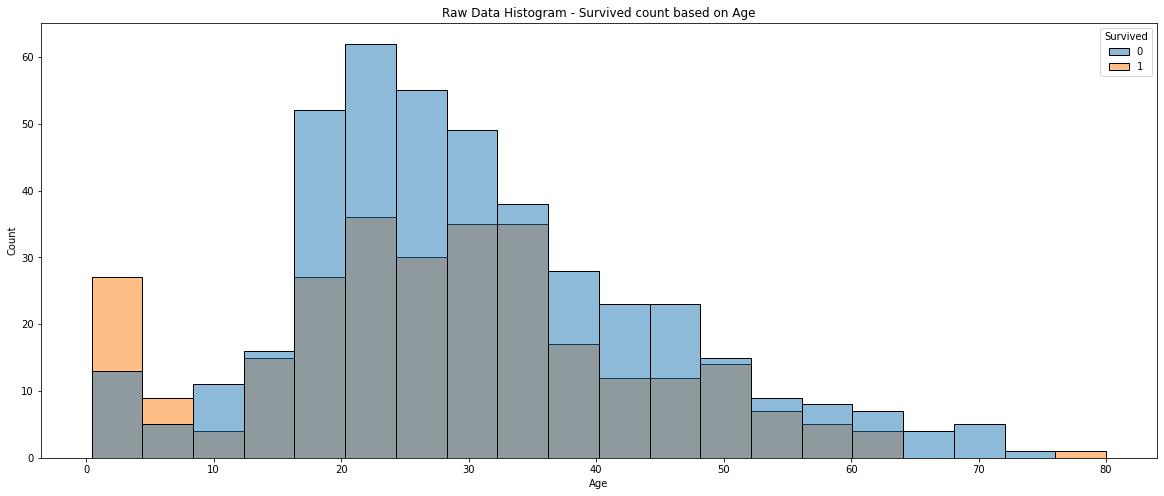

In [48]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=raw_data, x='Age', hue='Survived')
ax.set_title('Raw Data Histogram - Survived count based on Age')
ax = ax

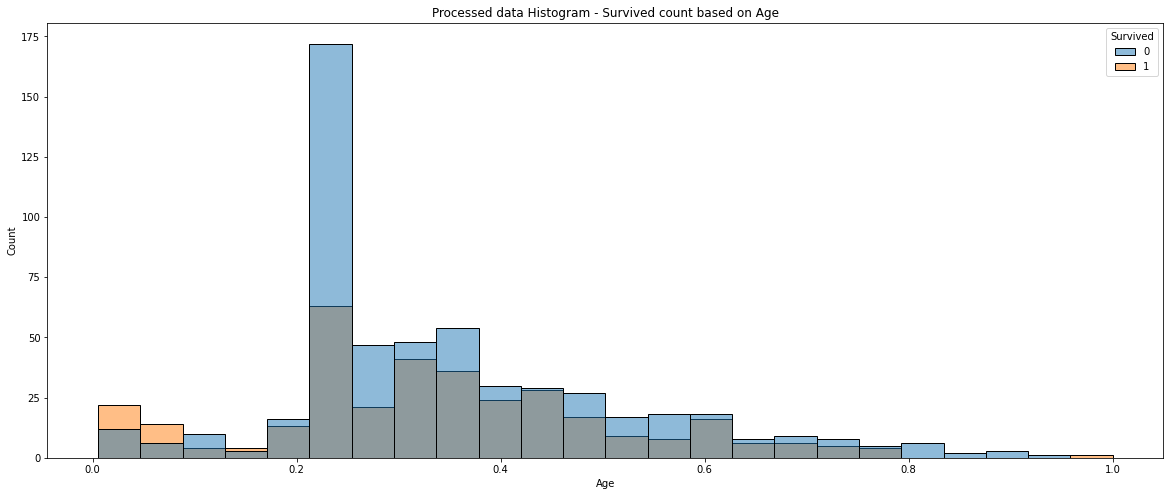

In [49]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=data, x='Age', hue='Survived')
ax.set_title('Processed data Histogram - Survived count based on Age')
ax = ax

Hum... looks like the processed data is not following same shape as the raw data. Probably a so big difference between both the raw and processed data are impacting in the precision of the model.

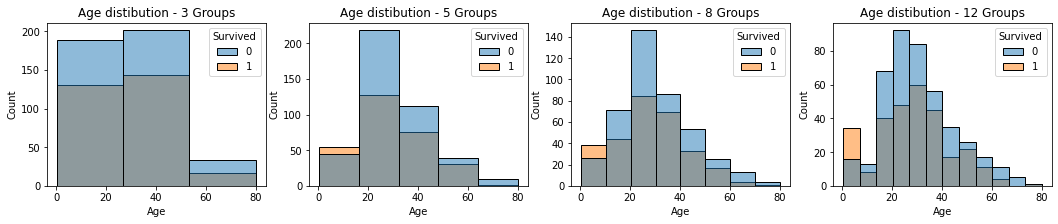

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 3))
axes = axes.flat

ax = sns.histplot(x='Age', hue='Survived', bins=3, data=raw_data, ax=axes[0])
ax.set_title('Age distibution - 3 Groups')

ax = sns.histplot(x='Age', hue='Survived', bins=5, data=raw_data, ax=axes[1])
ax.set_title('Age distibution - 5 Groups')

ax = sns.histplot(x='Age', hue='Survived', bins=8, data=raw_data, ax=axes[2])
ax.set_title('Age distibution - 8 Groups')

ax = sns.histplot(x='Age', hue='Survived', bins=12, data=raw_data, ax=axes[3])
ax.set_title('Age distibution - 12 Groups')

ax = ax

To fix this bias i can see two options:
* Set the Age based on probability to keep same shape in training and raw data
* Split the Ages in groups and turn this feature a categorical data

I'll try both solutions:

## Create two new age transformers

In [51]:
class AgeFillNullsKBinsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, bins=8):
        self.bins = bins
    
    def fit(self, X:pd.DataFrame, y):
        self._bin_size = X['Age'].max() / self.bins + 1
        self._title_age_mode = X.groupby(['Title'])['Age'].agg(lambda x: x.mode()[0]).to_dict()
        return self
        
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        
        data = self._set_age_by_title(data)
        data = self._group_age_bins(data)
        data = self._force_max_bin(data)
        
        return data
    
    def _set_age_by_title(self, data:pd.DataFrame):
        for key in self._title_age_mode:
            data.loc[(data['Title']==key) & (data['Age'].isna()), 'Age'] = self._title_age_mode[key]
        return data
            
    def _group_age_bins(self, data:pd.DataFrame):
        data['Age'] = data['Age'] // self._bin_size
        return data
        
    def _force_max_bin(self, data:pd.DataFrame):
        data['Age'] = data['Age'].apply(lambda x: x if x <= self.bins else self.bins)
        return data

In [52]:
class AgeFillNullsDistribTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, transform_strategy='mode'):
        self.transform_strategy = transform_strategy
    
    def fit(self, X:pd.DataFrame, y):
        self._title_age_mode = X.groupby(['Title'])['Age'].agg(lambda x: x.mode()[0]).to_dict()
        self._title_age_prob = dict()
        
        for key in self._title_age_mode:
            prob = dict()
            
            ages = self._get_age_by_title(X, key)
            counts = np.unique(ages, return_counts=True)
        
            prob['values'] = counts[0]
            prob['probs'] = counts[1] / sum(counts[1])
            prob['probs'][-1] = prob['probs'][-1] + (1 - sum(prob['probs']))
            
            self._title_age_prob[key] = prob
        
        return self
    
    def _get_age_by_title(self, X:pd.DataFrame, title):
        title_age_filter = (X['Title'] == title) & (X['Age'].notna())
        return X[title_age_filter]['Age']
        
    def transform(self, X:pd.DataFrame):
        data = X.copy()
        
        if self.transform_strategy == 'mode':
            data = self._set_age_by_mode(X)
            
        elif self.transform_strategy == 'prob':
            data = self._set_age_by_prob(X)
            
        else:
            raise Exception(f'Unknow option: {self.transform_strategy}')
        
        return data
    
    def _set_age_by_mode(self, data:pd.DataFrame):
        for key in self._title_age_mode:
            title_age_filter = (data['Title']==key) & (data['Age'].isna())
            data.loc[title_age_filter, 'Age'] = self._title_age_mode[key]
        return data
            
    def _set_age_by_prob(self, data:pd.DataFrame):
        for title in self._title_age_mode:
            
            title_age_filter = (data['Title']==title) & (data['Age'].isna())
            
            null_counts = len(data[title_age_filter])
            values = self._title_age_prob[title]['values']
            probs = self._title_age_prob[title]['probs']
            
            data.loc[title_age_filter, 'Age'] = np.random.choice(values, size=null_counts, p=probs)
        return data

## Visualize the data using the new transformations

In [53]:
np.random.seed(1)

### AgeFillNullsKBinsTransformer

In [54]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('age-nas', AgeFillNullsKBinsTransformer())
])

data = prepare_data_pipeline.fit_transform(raw_data, raw_data['Survived'])

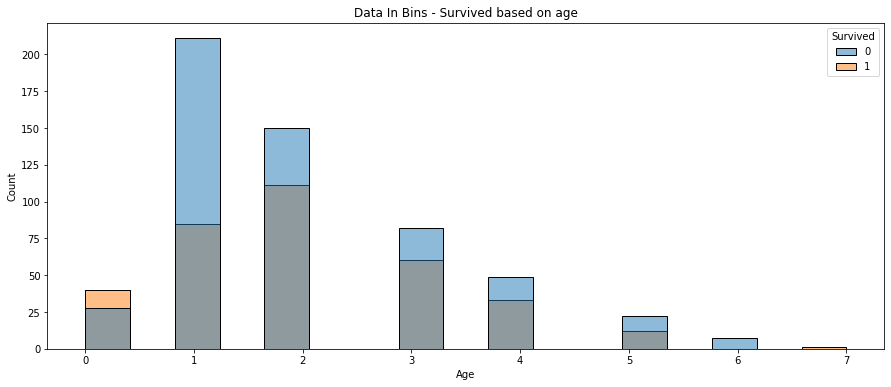

In [55]:
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=data, x='Age', hue='Survived')
ax.set_title('Data In Bins - Survived based on age')
ax = ax

### AgeFillNullsDistribTransformer - transform_strategy: mode

In [56]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('age-nas', AgeFillNullsDistribTransformer())
])

data = prepare_data_pipeline.fit_transform(raw_data, raw_data['Survived'])

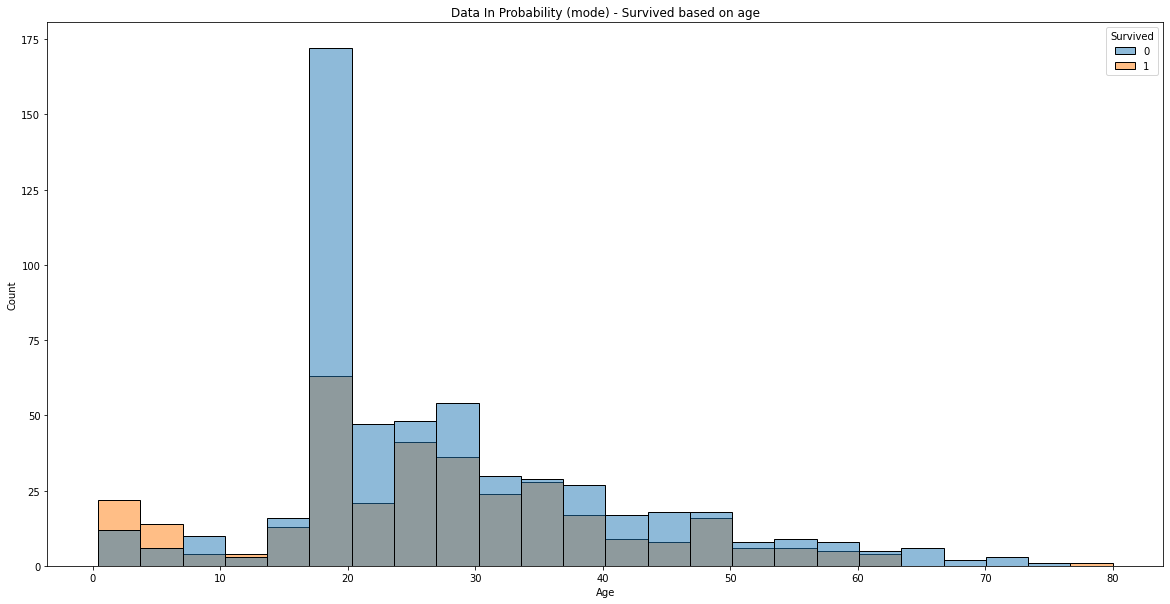

In [57]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=data, x='Age', hue='Survived')
ax.set_title('Data In Probability (mode) - Survived based on age')
ax = ax

### AgeFillNullsDistribTransformer - transform_strategy: prob

In [58]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('age-nas', AgeFillNullsDistribTransformer('prob'))
])

data = prepare_data_pipeline.fit_transform(raw_data, raw_data['Survived'])

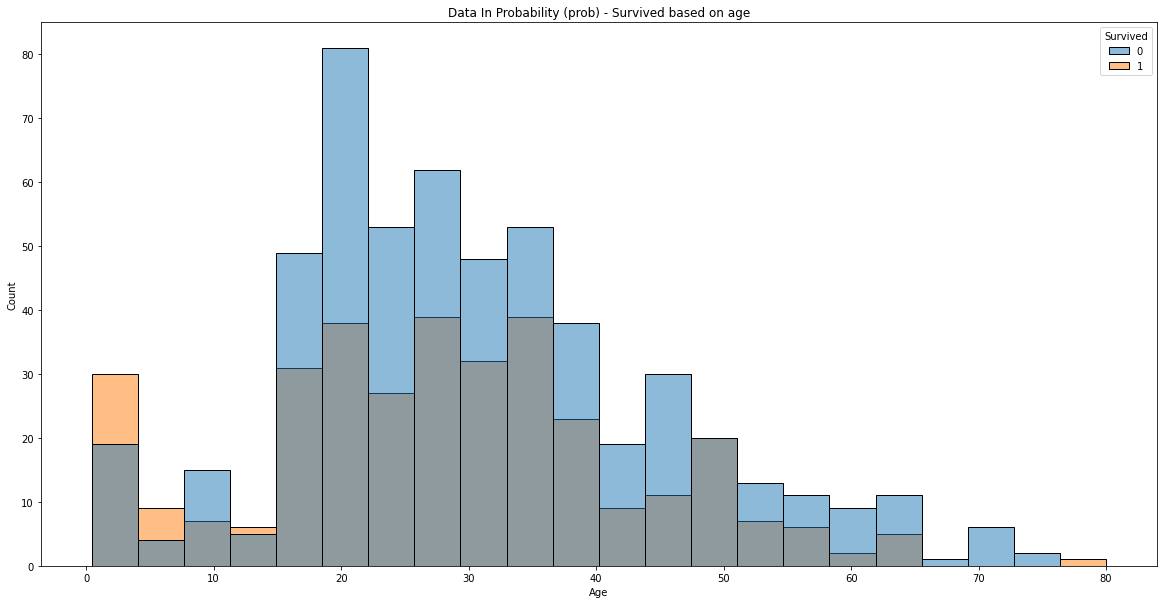

In [59]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=data, x='Age', hue='Survived')
ax.set_title('Data In Probability (prob) - Survived based on age')
ax = ax

### AgeFillNullsDistribTransformer - transform_strategy: prob + AgeFillNullsKBinsTransformer

In [60]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('age-nas-prod', AgeFillNullsDistribTransformer('prob')),
    ('age-nas-bins', AgeFillNullsKBinsTransformer())
])

data = prepare_data_pipeline.fit_transform(raw_data, raw_data['Survived'])

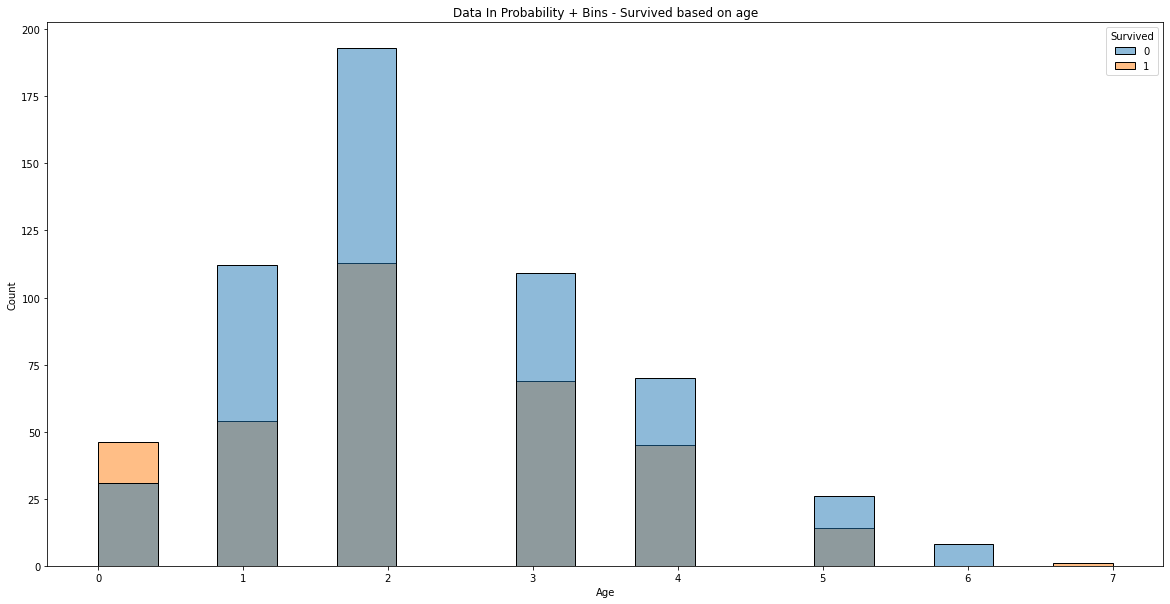

In [61]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=data, x='Age', hue='Survived')
ax.set_title('Data In Probability + Bins - Survived based on age')
ax = ax

Looks like the option using the probability logic to spread the data has a better shape.

I'm planning to use the prob strategy for training, but the mode strategy for predictions. I'm taking this decision now because I don't want to add randomness to my prediction dataset  

## Test a new data preparation strategy - Probability

### Create new train and test transformation pipelines 

In [62]:
train_prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('has-cabin', HasCabinTransformer()),
    ('age-nas', AgeFillNullsDistribTransformer('prob')),
    ('drop-cols', DropColumnsTransformer([ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title' ])),
    ('scaller', ScallerTransformer(['Age', 'SibSp', 'Parch'])),
    ('one-hot', OneHotTransformer(['Pclass', 'Sex']))
])

test_prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('has-cabin', HasCabinTransformer()),
    ('age-nas', AgeFillNullsDistribTransformer()),
    ('drop-cols', DropColumnsTransformer([ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title' ])),
    ('scaller', ScallerTransformer(['Age', 'SibSp', 'Parch'])),
    ('one-hot', OneHotTransformer(['Pclass', 'Sex']))
])

### Train new models with new pipelines

In [68]:
np.random.seed(1)

# get a fresh copy of the data to avoid any impact from previous executions
raw_data = pd.read_csv('./data/train.csv')
X_train, X_valid, y_train, y_valid = train_test_split(raw_data.drop('Survived', axis=1), raw_data['Survived'])

In [69]:
train_prepare_data_pipeline.fit(raw_data.drop(['Survived'], axis=1), raw_data['Survived'])
test_prepare_data_pipeline.fit(raw_data.drop(['Survived'], axis=1), raw_data['Survived'])

X_train = train_prepare_data_pipeline.transform(X_train)
X_valid = test_prepare_data_pipeline.transform(X_valid)

In [71]:
svc_pred = SVC().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
rand_forest_pred = RandomForestClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
dec_tree_pred = DecisionTreeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
sgdc_pred = SGDClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
ridge_prec = RidgeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
knn_pred = KNeighborsClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
gaussion_pred = GaussianNB().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
mlp_pred = MLPClassifier(max_iter=1000).fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())

In [72]:
svc_acc = accuracy_score(y_valid, svc_pred)
svc_f1 = f1_score(y_valid, svc_pred)
svc_recall = recall_score(y_valid, svc_pred)

rand_forest_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_recall = recall_score(y_valid, rand_forest_pred)

dec_tree_acc = accuracy_score(y_valid, dec_tree_pred)
dec_tree_f1 = f1_score(y_valid, dec_tree_pred)
dec_tree_recall = recall_score(y_valid, dec_tree_pred)

sgdc_acc = accuracy_score(y_valid, sgdc_pred)
sgdc_f1 = f1_score(y_valid, sgdc_pred)
sgdc_recall = recall_score(y_valid, sgdc_pred)

ridge_acc = accuracy_score(y_valid, ridge_prec)
ridge_f1 = f1_score(y_valid, ridge_prec)
ridge_recall = recall_score(y_valid, ridge_prec)

knn_acc = accuracy_score(y_valid, knn_pred)
knn_f1 = f1_score(y_valid, knn_pred)
knn_recall = recall_score(y_valid, knn_pred)

gaussion_acc = accuracy_score(y_valid, gaussion_pred)
gaussion_f1 = f1_score(y_valid, gaussion_pred)
gaussion_recall = recall_score(y_valid, gaussion_pred)

mlp_acc = accuracy_score(y_valid, mlp_pred)
mlp_f1 = f1_score(y_valid, mlp_pred)
mlp_recall = recall_score(y_valid, mlp_pred)

In [73]:
print(f'Classifier: SVC - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: RandomForestClassifier - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: DecisionTreeClassifier - Accuracy: {dec_tree_acc} - f1 score: {dec_tree_f1} - recall: {dec_tree_recall}')
print(f'Classifier: SGDClassifier - Accuracy: {sgdc_acc} - f1 score: {sgdc_f1} - recall: {sgdc_recall}')
print(f'Classifier: RidgeClassifier - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: KNeighborsClassifier - Accuracy: {knn_acc} - f1 score: {knn_f1} - recall: {knn_recall}')
print(f'Classifier: GaussianNB - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: MLPClassifier - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')

Classifier: SVC - Accuracy: 0.7757847533632287 - f1 score: 0.6951219512195121 - recall: 0.6
Classifier: RandomForestClassifier - Accuracy: 0.7847533632286996 - f1 score: 0.710843373493976 - recall: 0.6210526315789474
Classifier: DecisionTreeClassifier - Accuracy: 0.7757847533632287 - f1 score: 0.7023809523809524 - recall: 0.6210526315789474
Classifier: SGDClassifier - Accuracy: 0.7623318385650224 - f1 score: 0.6580645161290322 - recall: 0.5368421052631579
Classifier: RidgeClassifier - Accuracy: 0.7982062780269058 - f1 score: 0.7513812154696132 - recall: 0.7157894736842105
Classifier: KNeighborsClassifier - Accuracy: 0.7668161434977578 - f1 score: 0.6666666666666666 - recall: 0.5473684210526316
Classifier: GaussianNB - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Classifier: MLPClassifier - Accuracy: 0.7802690582959642 - f1 score: 0.6993865030674846 - recall: 0.6


Not a good result. I'll try the bins strategy now

## Test a new data preparation strategy - bins

### Create new train and test transformation pipelines 

In [111]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('has-cabin', HasCabinTransformer()),
    ('age-nas', AgeFillNullsKBinsTransformer(5)),
    ('drop-cols', DropColumnsTransformer([ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title' ])),
    ('scaller', ScallerTransformer(['SibSp', 'Parch'])),
    ('one-hot', OneHotTransformer(['Pclass', 'Sex', 'Age']))
])

### Train new models with new pipeline

In [112]:
np.random.seed(1)

# get a fresh copy of the data to avoid any impact from previous executions
raw_data = pd.read_csv('./data/train.csv')
X_train, X_valid, y_train, y_valid = train_test_split(raw_data.drop('Survived', axis=1), raw_data['Survived'])

In [113]:
prepare_data_pipeline.fit(raw_data.drop(['Survived'], axis=1), raw_data['Survived'])

X_train = prepare_data_pipeline.transform(X_train)
X_valid = prepare_data_pipeline.transform(X_valid)

In [114]:
svc_pred = SVC().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
rand_forest_pred = RandomForestClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
dec_tree_pred = DecisionTreeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
sgdc_pred = SGDClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
ridge_prec = RidgeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
knn_pred = KNeighborsClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
gaussion_pred = GaussianNB().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
mlp_pred = MLPClassifier(max_iter=1000).fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())

In [115]:
svc_acc = accuracy_score(y_valid, svc_pred)
svc_f1 = f1_score(y_valid, svc_pred)
svc_recall = recall_score(y_valid, svc_pred)

rand_forest_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_recall = recall_score(y_valid, rand_forest_pred)

dec_tree_acc = accuracy_score(y_valid, dec_tree_pred)
dec_tree_f1 = f1_score(y_valid, dec_tree_pred)
dec_tree_recall = recall_score(y_valid, dec_tree_pred)

sgdc_acc = accuracy_score(y_valid, sgdc_pred)
sgdc_f1 = f1_score(y_valid, sgdc_pred)
sgdc_recall = recall_score(y_valid, sgdc_pred)

ridge_acc = accuracy_score(y_valid, ridge_prec)
ridge_f1 = f1_score(y_valid, ridge_prec)
ridge_recall = recall_score(y_valid, ridge_prec)

knn_acc = accuracy_score(y_valid, knn_pred)
knn_f1 = f1_score(y_valid, knn_pred)
knn_recall = recall_score(y_valid, knn_pred)

gaussion_acc = accuracy_score(y_valid, gaussion_pred)
gaussion_f1 = f1_score(y_valid, gaussion_pred)
gaussion_recall = recall_score(y_valid, gaussion_pred)

mlp_acc = accuracy_score(y_valid, mlp_pred)
mlp_f1 = f1_score(y_valid, mlp_pred)
mlp_recall = recall_score(y_valid, mlp_pred)

In [116]:
print(f'Classifier: SVC - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: RandomForestClassifier - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: DecisionTreeClassifier - Accuracy: {dec_tree_acc} - f1 score: {dec_tree_f1} - recall: {dec_tree_recall}')
print(f'Classifier: SGDClassifier - Accuracy: {sgdc_acc} - f1 score: {sgdc_f1} - recall: {sgdc_recall}')
print(f'Classifier: RidgeClassifier - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: KNeighborsClassifier - Accuracy: {knn_acc} - f1 score: {knn_f1} - recall: {knn_recall}')
print(f'Classifier: GaussianNB - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: MLPClassifier - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')

Classifier: SVC - Accuracy: 0.7623318385650224 - f1 score: 0.6442953020134229 - recall: 0.5052631578947369
Classifier: RandomForestClassifier - Accuracy: 0.7802690582959642 - f1 score: 0.7100591715976332 - recall: 0.631578947368421
Classifier: DecisionTreeClassifier - Accuracy: 0.7757847533632287 - f1 score: 0.7023809523809524 - recall: 0.6210526315789474
Classifier: SGDClassifier - Accuracy: 0.7713004484304933 - f1 score: 0.7243243243243243 - recall: 0.7052631578947368
Classifier: RidgeClassifier - Accuracy: 0.7937219730941704 - f1 score: 0.735632183908046 - recall: 0.6736842105263158
Classifier: KNeighborsClassifier - Accuracy: 0.7533632286995515 - f1 score: 0.6451612903225806 - recall: 0.5263157894736842
Classifier: GaussianNB - Accuracy: 0.7757847533632287 - f1 score: 0.7474747474747476 - recall: 0.7789473684210526
Classifier: MLPClassifier - Accuracy: 0.7713004484304933 - f1 score: 0.6946107784431138 - recall: 0.6105263157894737


Looks like the Age column is not a problem

## Look again the data

In [117]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


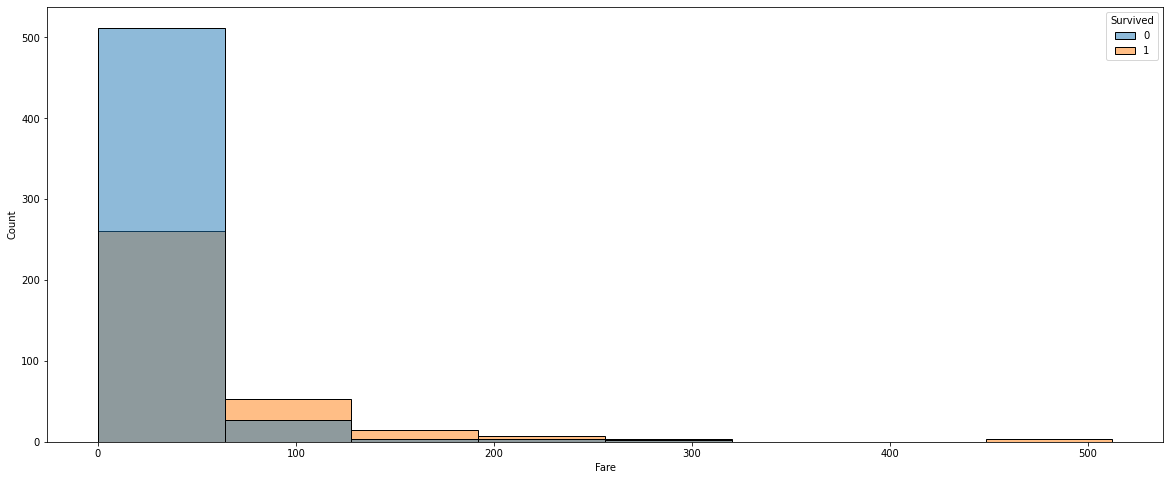

In [122]:
plt.figure(figsize=(20,8))
ax = sns.histplot(data=raw_data, x='Fare', hue='Survived', bins=8)
ax = ax

I've remored the Fare column in all models, but maybe this feature can be usefull. I'll try to train a new model using this column instead of discard it.

## Train a new ML Model adding the Fare column to the train data

In [125]:
np.random.seed(1)

# get a fresh copy of the data to avoid any impact from previous executions
raw_data = pd.read_csv('./data/train.csv')
X_train, X_valid, y_train, y_valid = train_test_split(raw_data.drop('Survived', axis=1), raw_data['Survived'])

### Create the new pipeline

In [127]:
prepare_data_pipeline = Pipeline([
    ('extr-title', ExtractTitleTransformer()),
    ('has-cabin', HasCabinTransformer()),
    ('age-nas', AgeFillNullsTransformer()),
    ('drop-cols', DropColumnsTransformer([ 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Title' ])),
    ('scaller', ScallerTransformer(['Age', 'SibSp', 'Parch', 'Fare'])),
    ('one-hot', OneHotTransformer(['Pclass', 'Sex']))
])

### Prepare the data for training

In [128]:
prepare_data_pipeline.fit(raw_data.drop(['Survived'], axis=1), raw_data['Survived'])

X_train = prepare_data_pipeline.transform(X_train)
X_valid = prepare_data_pipeline.transform(X_valid)

### Check the features correlation

In [130]:
temp = X_train.copy()
temp['Survived'] = y_train

temp.corr().style.background_gradient(cmap='coolwarm')

,Age,SibSp,Parch,Fare,HasCabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Survived
Age,1.000000,-0.216909,-0.130083,0.133102,0.249365,0.318813,0.067604,-0.327377,-0.040793,0.040793,-0.042307
SibSp,-0.216909,1.000000,0.405897,0.189206,-0.008039,-0.028649,-0.044505,0.060822,0.135225,-0.135225,-0.021709
Parch,-0.130083,0.405897,1.000000,0.246252,0.049788,-0.005237,0.008108,-0.002155,0.258208,-0.258208,0.119533
Fare,0.133102,0.189206,0.246252,1.000000,0.532314,0.638511,-0.118503,-0.448180,0.182498,-0.182498,0.260757
HasCabin,0.249365,-0.008039,0.049788,0.532314,1.000000,0.780073,-0.177212,-0.521039,0.120940,-0.120940,0.319613
Pclass_1,0.318813,-0.028649,-0.005237,0.638511,0.780073,1.000000,-0.284131,-0.621391,0.090658,-0.090658,0.277531
Pclass_2,0.067604,-0.044505,0.008108,-0.118503,-0.177212,-0.284131,1.000000,-0.574652,0.081375,-0.081375,0.119198
Pclass_3,-0.327377,0.060822,-0.002155,-0.448180,-0.521039,-0.621391,-0.574652,1.000000,-0.143881,0.143881,-0.334300
Sex_female,-0.040793,0.135225,0.258208,0.182498,0.120940,0.090658,0.081375,-0.143881,1.000000,-1.000000,0.539057
Sex_male,0.040793,-0.135225,-0.258208,-0.182498,-0.120940,-0.090658,-0.081375,0.143881,-1.000000,1.000000,-0.539057


Ok, i can see some correlation between Fare and Survived columns. Time to try the training

In [131]:
svc_pred = SVC().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
rand_forest_pred = RandomForestClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
dec_tree_pred = DecisionTreeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
sgdc_pred = SGDClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
ridge_prec = RidgeClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
knn_pred = KNeighborsClassifier().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
gaussion_pred = GaussianNB().fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())
mlp_pred = MLPClassifier(max_iter=1000).fit(X_train.copy(), y_train.copy()).predict(X_valid.copy())

In [132]:
svc_acc = accuracy_score(y_valid, svc_pred)
svc_f1 = f1_score(y_valid, svc_pred)
svc_recall = recall_score(y_valid, svc_pred)

rand_forest_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_recall = recall_score(y_valid, rand_forest_pred)

dec_tree_acc = accuracy_score(y_valid, dec_tree_pred)
dec_tree_f1 = f1_score(y_valid, dec_tree_pred)
dec_tree_recall = recall_score(y_valid, dec_tree_pred)

sgdc_acc = accuracy_score(y_valid, sgdc_pred)
sgdc_f1 = f1_score(y_valid, sgdc_pred)
sgdc_recall = recall_score(y_valid, sgdc_pred)

ridge_acc = accuracy_score(y_valid, ridge_prec)
ridge_f1 = f1_score(y_valid, ridge_prec)
ridge_recall = recall_score(y_valid, ridge_prec)

knn_acc = accuracy_score(y_valid, knn_pred)
knn_f1 = f1_score(y_valid, knn_pred)
knn_recall = recall_score(y_valid, knn_pred)

gaussion_acc = accuracy_score(y_valid, gaussion_pred)
gaussion_f1 = f1_score(y_valid, gaussion_pred)
gaussion_recall = recall_score(y_valid, gaussion_pred)

mlp_acc = accuracy_score(y_valid, mlp_pred)
mlp_f1 = f1_score(y_valid, mlp_pred)
mlp_recall = recall_score(y_valid, mlp_pred)

In [133]:
print(f'Classifier: SVC - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: RandomForestClassifier - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: DecisionTreeClassifier - Accuracy: {dec_tree_acc} - f1 score: {dec_tree_f1} - recall: {dec_tree_recall}')
print(f'Classifier: SGDClassifier - Accuracy: {sgdc_acc} - f1 score: {sgdc_f1} - recall: {sgdc_recall}')
print(f'Classifier: RidgeClassifier - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: KNeighborsClassifier - Accuracy: {knn_acc} - f1 score: {knn_f1} - recall: {knn_recall}')
print(f'Classifier: GaussianNB - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: MLPClassifier - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')

Classifier: SVC - Accuracy: 0.7847533632286996 - f1 score: 0.710843373493976 - recall: 0.6210526315789474
Classifier: RandomForestClassifier - Accuracy: 0.7847533632286996 - f1 score: 0.7176470588235295 - recall: 0.6421052631578947
Classifier: DecisionTreeClassifier - Accuracy: 0.7488789237668162 - f1 score: 0.688888888888889 - recall: 0.6526315789473685
Classifier: SGDClassifier - Accuracy: 0.7668161434977578 - f1 score: 0.670886075949367 - recall: 0.5578947368421052
Classifier: RidgeClassifier - Accuracy: 0.7982062780269058 - f1 score: 0.7486033519553073 - recall: 0.7052631578947368
Classifier: KNeighborsClassifier - Accuracy: 0.7713004484304933 - f1 score: 0.6946107784431138 - recall: 0.6105263157894737
Classifier: GaussianNB - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Classifier: MLPClassifier - Accuracy: 0.7802690582959642 - f1 score: 0.6993865030674846 - recall: 0.6


I can see a better performance for some of the models.

The new performance rank is:
* RidgeClassifier - 79%
* SVC, RandomForestClassifier, MLPClassifier - 78%
* KNeighborsClassifier and GaussianNB - 77%

## Tune top models

In [156]:
param_grid = [
    { 'alpha': [1.0, 0.1, 0.01], 'fit_intercept': [True, False], 'tol': [0.001, 0.01] }
]

grid_search = GridSearchCV(RidgeClassifier(), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

ridge_pred = grid_search.predict(X_valid.copy())
ridge = grid_search.best_estimator_

ridge_grid_acc = accuracy_score(y_valid, ridge_prec)
ridge_grid_f1 = f1_score(y_valid, ridge_prec)
ridge_grid_recall = recall_score(y_valid, ridge_prec)

print(f'Classifier: RidgeClassifier (Default) - Accuracy: {ridge_acc} - f1 score: {ridge_f1} - recall: {ridge_recall}')
print(f'Classifier: RidgeClassifier (Grid) - Accuracy: {ridge_grid_acc} - f1 score: {ridge_grid_f1} - recall: {ridge_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: RidgeClassifier (Default) - Accuracy: 0.7982062780269058 - f1 score: 0.7486033519553073 - recall: 0.7052631578947368
Classifier: RidgeClassifier (Grid) - Accuracy: 0.7982062780269058 - f1 score: 0.7486033519553073 - recall: 0.7052631578947368
Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'tol': 0.001}


Same result again

In [157]:
param_grid = [
    { 'C': [1.0, 0.1, 0.01], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

svc_pred = grid_search.predict(X_valid.copy())
svc = grid_search.best_estimator_

svc_grid_acc = accuracy_score(y_valid, svc_pred)
svc_grid_f1 = f1_score(y_valid, svc_pred)
svc_grid_recall = recall_score(y_valid, svc_pred)

print(f'Classifier: SVC (Default) - Accuracy: {svc_acc} - f1 score: {svc_f1} - recall: {svc_recall}')
print(f'Classifier: SVC (Grid) - Accuracy: {svc_grid_acc} - f1 score: {svc_grid_f1} - recall: {svc_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: SVC (Default) - Accuracy: 0.7847533632286996 - f1 score: 0.710843373493976 - recall: 0.6210526315789474
Classifier: SVC (Grid) - Accuracy: 0.7892376681614349 - f1 score: 0.718562874251497 - recall: 0.631578947368421
Best Parameters: {'C': 1.0, 'kernel': 'poly'}


Not much difference

In [158]:
param_grid = [
    { 
        'n_estimators': [200, 100, 50], 'criterion': ["gini", "entropy"], 'max_depth': [None, 100, 50, 10],
        'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10, 20]
    }
]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

rand_forest_pred = grid_search.predict(X_valid.copy())
rand_forest = grid_search.best_estimator_

rand_forest_grid_acc = accuracy_score(y_valid, rand_forest_pred)
rand_forest_grid_f1 = f1_score(y_valid, rand_forest_pred)
rand_forest_grid_recall = recall_score(y_valid, rand_forest_pred)

print(f'Classifier: RandomForestClassifier (Default) - Accuracy: {rand_forest_acc} - f1 score: {rand_forest_f1} - recall: {rand_forest_recall}')
print(f'Classifier: RandomForestClassifier (Grid) - Accuracy: {rand_forest_grid_acc} - f1 score: {rand_forest_grid_f1} - recall: {rand_forest_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: RandomForestClassifier (Default) - Accuracy: 0.7847533632286996 - f1 score: 0.7176470588235295 - recall: 0.6421052631578947
Classifier: RandomForestClassifier (Grid) - Accuracy: 0.8026905829596412 - f1 score: 0.7317073170731707 - recall: 0.631578947368421
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Looks way better!

In [159]:
param_grid = [
    { 
        'hidden_layer_sizes': [(100, 50, 25), (50, 25, 5), (25, 5, 1)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.01, 0.001, 0.0001]
    }
]

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

mlp_pred = grid_search.predict(X_valid.copy())
mlp = grid_search.best_estimator_

mlp_grid_acc = accuracy_score(y_valid, mlp_pred)
mlp_grid_f1 = f1_score(y_valid, mlp_pred)
mlp_grid_recall = recall_score(y_valid, mlp_pred)

print(f'Classifier: MLPClassifier (Default) - Accuracy: {mlp_acc} - f1 score: {mlp_f1} - recall: {mlp_recall}')
print(f'Classifier: MLPClassifier (Grid) - Accuracy: {mlp_grid_acc} - f1 score: {mlp_grid_f1} - recall: {mlp_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: MLPClassifier (Default) - Accuracy: 0.7802690582959642 - f1 score: 0.6993865030674846 - recall: 0.6
Classifier: MLPClassifier (Grid) - Accuracy: 0.7713004484304933 - f1 score: 0.679245283018868 - recall: 0.5684210526315789
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 25, 5), 'solver': 'adam'}


Exact same result

In [160]:
param_grid = [
    { 
        'n_neighbors': [11, 9, 7, 5, 3], 'weights':['uniform', 'distance']
    }
]

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

knn_pred = grid_search.predict(X_valid.copy())
knn = grid_search.best_estimator_

knn_grid_acc = accuracy_score(y_valid, knn_pred)
knn_grid_f1 = f1_score(y_valid, knn_pred)
knn_grid_recall = recall_score(y_valid, knn_pred)

print(f'Classifier: KNeighborsClassifier (Default) - Accuracy: {knn_acc} - f1 score: {knn_f1} - recall: {knn_recall}')
print(f'Classifier: KNeighborsClassifier (Grid) - Accuracy: {knn_grid_acc} - f1 score: {knn_grid_f1} - recall: {knn_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: KNeighborsClassifier (Default) - Accuracy: 0.7713004484304933 - f1 score: 0.6946107784431138 - recall: 0.6105263157894737
Classifier: KNeighborsClassifier (Grid) - Accuracy: 0.7892376681614349 - f1 score: 0.7344632768361581 - recall: 0.6842105263157895
Best Parameters: {'n_neighbors': 3, 'weights': 'uniform'}


No much difference here

In [161]:
param_grid = [
    { 
        'var_smoothing': [0.000000001, 0.00001, 0.1]
    }
]

grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring=make_scorer(f1_score, ))
grid_search.fit(X_train.copy(), y_train.copy())

gaussian_pred = grid_search.predict(X_valid.copy())
gaussian = grid_search.best_estimator_

gaussian_grid_acc = accuracy_score(y_valid, gaussian_pred)
gaussian_grid_f1 = f1_score(y_valid, gaussian_pred)
gaussian_grid_recall = recall_score(y_valid, gaussian_pred)

print(f'Classifier: GaussianNB (Default) - Accuracy: {gaussion_acc} - f1 score: {gaussion_f1} - recall: {gaussion_recall}')
print(f'Classifier: GaussianNB (Grid) - Accuracy: {gaussian_grid_acc} - f1 score: {gaussian_grid_f1} - recall: {gaussian_grid_recall}')
print(f'Best Parameters: {grid_search.best_params_}')

Classifier: GaussianNB (Default) - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Classifier: GaussianNB (Grid) - Accuracy: 0.7757847533632287 - f1 score: 0.7448979591836735 - recall: 0.7684210526315789
Best Parameters: {'var_smoothing': 1e-09}


Same result again

In [165]:
# using 3 of best models
voting = VotingClassifier([('Ridge', ridge), ('SVC', svc), ('rnd_forest', rand_forest)])
voting.fit(X_train.copy(), y_train.copy())
voting_pred = voting.predict(X_valid.copy())

voting_acc = accuracy_score(y_valid, voting_pred)
voting_f1 = f1_score(y_valid, voting_pred)
voting_recall = recall_score(y_valid, voting_pred)

print(f'Classifier: VotingClassifier - Accuracy: {voting_acc} - f1 score {voting_f1} - recall {voting_recall}')

Classifier: VotingClassifier - Accuracy: 0.7937219730941704 - f1 score 0.7228915662650601 - recall 0.631578947368421


A bit worst than the best model (RidgeClassifier).

## Conclusion

I've create a pipeline to clean the data, I could test some different models, I did some effort for otimization, a new review in the data to test new formats, test new models....

With all this work, I couldn't improve the accuracy on validation data. I believe I need more data or more features to improve the performance of the predictions.

For now I'm keeping my first submission with **77.511%** accuracy.